In [118]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression

In [152]:
file = "./Midprices/min_data.csv"
try:
    df = pd.read_csv(file, index_col=0)
    df.index = pd.to_datetime(df.index)

except:
    #df_AAPL = pd.read_csv("./Midprices/AAPL_1min_sample.csv", index_col=0)
    #df_AAPL = df_AAPL["close"]
    df_AMZN = pd.read_csv("./Midprices/AMZN_1min_sample.csv", index_col=0)
    df_AMZN = df_AMZN["close"]
    df_GOOG = pd.read_csv("./Midprices/GOOG_1min_sample.csv", index_col=0)
    df_GOOG = df_GOOG["close"]
    df_META = pd.read_csv("./Midprices/META_1min_sample.csv", index_col=0)
    df_META = df_META["close"]
    #df_NVDA = pd.read_csv("./Midprices/NVDA_1min_sample.csv", index_col=0)
    #df_NVDA = df_NVDA["close"]
    #df = pd.concat([df_AAPL, df_AMZN, df_GOOG, df_META, df_NVDA], axis=1, join='inner')
    df = pd.concat([df_AMZN, df_GOOG, df_META], axis=1, join='inner')
    #df.columns = ["AAPL", "AMZN", "GOOG", "META", "NVDA"]
    df.columns = ["AMZN", "GOOG", "META"]
    df.to_csv(file)
    df.index = pd.to_datetime(df.index)


In [157]:
file = "./Midprices/min_data_2014_11.csv"
try:
    df = pd.read_csv(file, index_col=0)
    df.index = pd.to_datetime(df.index)

except:

    df_AMZN = pd.read_csv("./Midprices/Midprice_2014_11_AMZN.csv", index_col=0)
    df_AMZN = df_AMZN["close"]
    df_GOOG = pd.read_csv("./Midprices/Midprice_2014_11_GOOGL.csv", index_col=0)
    df_GOOG = df_GOOG["close"]
    df_META = pd.read_csv("./Midprices/Midprice_2014_11_META.csv", index_col=0)
    df_META = df_META["close"]
    df = pd.concat([df_AMZN, df_GOOG, df_META], axis=1, join='inner')
    df.columns = ["AMZN", "GOOG", "META"]
    df.to_csv(file)
    df.index = pd.to_datetime(df.index)


In [158]:
df = df[df.index.date == min(df.index.date)]
df = df.resample("1min").ffill()

In [126]:
def pi(tau: np.ndarray, alpha_t: np.ndarray, params):
    """
    Compute the optimal investment strategy π*.

    Parameters:
    Let n be the number of assets and T the number of time steps
    - tau (np.ndarray): Time-to-maturity vector (shape: (T,))
    - alpha_t (np.ndarray): Co-integration factor vector (shape: (T,))
    - params: Tuple containing (gamma, omega, delta, nu, a)
        - gamma (float): Risk aversion parameter
        - omega (ndarray): Covariance matrix (n, n)
        - delta (ndarray): Sensitivity vector (n, 1)
        - nu (ndarray): Drift vector (n, 1)
        - a (ndarray): Vector of weights (n, 1)

    Returns:
    - np.ndarray: Optimal investment matrix (T, n)
    """
    # Unpack parameters
    gamma, omega, delta, nu, a = params
    t = len(tau)

    A = np.diag(a)  # Diagonal matrix of a shape n x n
    omega_inv = np.linalg.inv(omega) # Inverse of omega

    # Compute common terms
    delta_T_omega = delta.T @ omega # Shape: (1, n)
    delta_T_omega_delta = delta_T_omega @ delta # Shape: (1, 1)
    delta_T_omega_nu = delta_T_omega @ nu # Shape: (1, 1)

    # Reshape tau and alpha_t to ensure correct broadcasting
    tau = tau[:, None]  # Shape (T, 1)
    alpha_t = alpha_t[:, None]  # Shape (T, 1)
    nu = nu[:, None]  # Shape (n,)
    delta = delta[:, None]  # Shape (n,)
    a = a[:, None]  # Shape (n,)

    # Compute first term: Omega inverse applied to (delta * alpha + nu)
    term1 = omega_inv @ (delta @ alpha_t.T + nu @ np.ones((1,t)))  # Shape: (n, T)


    # Compute second term: Adjustment based on short-term alpha and co-integration factor
    term2 = (1 / 2 * tau * (alpha_t - 2 * delta_T_omega_nu / delta_T_omega_delta))  # (T, 1)
    term3 = (1 / 4 * np.trace(A @ omega) * tau**2)  # (T, 1)

    # Final computation (broadcasted across tau and alpha_t)
    result = (1 / gamma) * (term1 +  a @ (delta_T_omega_delta * (term2 + term3).T))  # (n, T)
    
    return result.T  # (T, n)

def m(Y, tau : np.ndarray, alpha_t : np.ndarray, params):
    return pi(tau, alpha_t, params) / Y

In [127]:
def estimate_VAR(df_estimate):

    df_lagged = df_estimate.shift(1).dropna()
    df_current = df_estimate.iloc[1:]

    # Extract values
    X_estimate = df_lagged.values  # Lagged variables (t-1)
    Y_estimate = df_current.values  # Current values at time t

    # Fit multivariate regression for each asset (column)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_estimate, Y_estimate)

    # Coefficients
    C = model.coef_  # (3x3 matrix)
    b = model.intercept_  # (3x1 vector)
    # Compute residuals
    Y_pred = model.predict(X_estimate)  # Predicted values using Y_{t-1}
    residuals = Y_estimate - Y_pred  # Compute residuals

    # Estimate covariance matrix (Ω)
    omega = np.cov(residuals, rowvar=False)
    return C, b, omega

def estimate_params(C, b, omega):
    kappa = np.eye(len(C)) - C
    theta = np.linalg.inv(kappa) @ b
    eig = np.linalg.eig(kappa)
    U = eig.eigenvectors
    D = eig.eigenvalues
    D_tilde = D
    D_tilde[1:] = 0
    kappa_tilde = U @ np.diag(D_tilde) @ np.linalg.inv(U)

    a = - kappa_tilde[0, :]
    delta = kappa_tilde[:, 0] / kappa_tilde[0, 0]
    nu = kappa_tilde @ theta + 0.5 * np.diag(omega) 
    
    return a, delta, nu

In [154]:
# Rolling window, using the last 400 points to estimate the parameters for the next 400 points
window_size = 400

keep_size = 10

portfolio = None
weight = None
for i in range(0, len(df) - window_size, keep_size):
    df_estimate = df.iloc[i:i+window_size].copy()
    df_estimate = df_estimate.resample("1min").ffill()
    df_portfolio = df.iloc[i+window_size:i+window_size+keep_size].copy()
    df_portfolio = df_portfolio.resample("1min").ffill()
    df_estimate_log = np.log(df_estimate) 
    df_portfolio_log = np.log(df_portfolio)
    # Estimate VAR model
    C, b, omega = estimate_VAR(df_estimate_log)

    # Estimate parameters
    a, delta, nu = estimate_params(C, b, omega)

    # price vector
    prices = df_portfolio.values

    # returns vector
    returns = df_portfolio.pct_change()
    returns = returns.dropna()
    returns = returns.values


    params = 1, omega, delta, nu, a

    # Calculate alpha and tau
    df_portfolio["alpha"] = df_portfolio_log.mul(a, axis=1).sum(axis=1)
    t = len(df)
    df_portfolio["tau"] = (t - np.arange(i, i + len(df_portfolio))) / t
    
    # Compute portfolio
    weight_i = m(prices, df_portfolio["tau"].values, df_portfolio["alpha"].values, params)
    portfolio_i = (weight_i[:-1] @ returns.T).sum(axis=1)

    if portfolio is None:
        weight = weight_i
        portfolio = portfolio_i
    else:
        weight = np.vstack((weight, weight_i))
        portfolio = np.concatenate((portfolio, portfolio_i))



/Users/bluee/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bluee/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: >

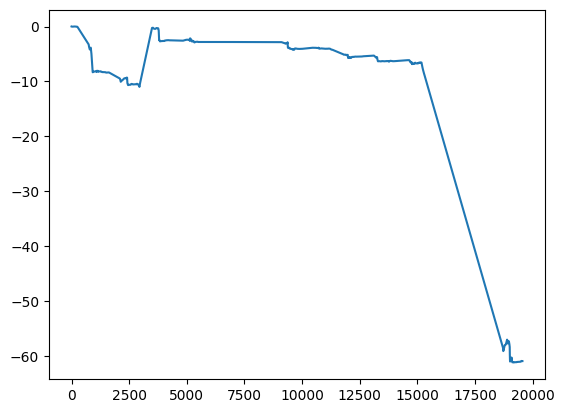

In [155]:
p = pd.Series(portfolio)
p.cumsum().plot()

/Users/bluee/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bluee/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: >

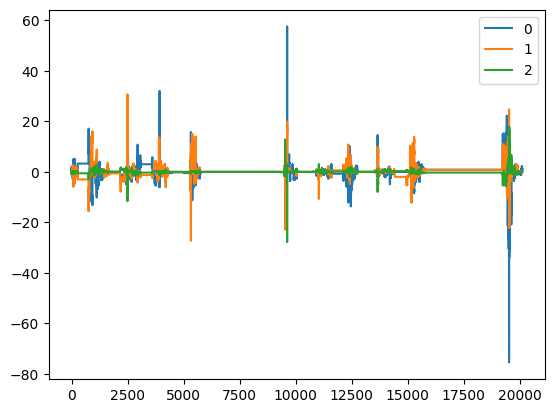

In [156]:
w = pd.DataFrame(weight)
w.plot()